In [1]:
import time
import pickle
import numpy as np
import pprint
import matplotlib.pyplot as plt
from tqdm import tqdm 
import json
from dateutil.parser import parse

In [2]:
from rdbtools import RdbParser, RdbCallback
from rdbtools.encodehelpers import bytes_to_unicode

class PublishCallback(RdbCallback):

    def __init__(self, is_unicode=False, start_ts=float('-inf'), stop_ts=float('+inf')):
        super(PublishCallback, self).__init__(string_escape=None)
        self.ranges = {}
        self.start = start_ts
        self.stop = stop_ts
        self.is_unicode = is_unicode

    def encode_key(self, key):
        return bytes_to_unicode(key, self._escape, skip_printable=True)

    def encode_value(self, val):
        if self.is_unicode:
            return bytes_to_unicode(val, self._escape)
        return val

    def start_sorted_set(self, key, length, expiry, info):
        self.ranges[self.encode_key(key)] = []

    def zadd(self, key, score, member):
        if self.start <= score <= self.stop:
            self.ranges[self.encode_key(key)].append((self.encode_value(member), round(score)))

    def end_sorted_set(self, key):
        encoded_key = self.encode_key(key)
        self.ranges[encoded_key] = list(reversed(self.ranges[encoded_key]))


def parse_dump_file(dump_file, start_ts=float("-inf"), stop_ts=float("+inf")):
    """Parse a redis dump file (rdb) and return the data within.

    Only supports SortedSet.

    Args:
        dump_file (str): Rdb path
        start_ts (float): timestamp of the first value to publish
        stop_ts (float): timestamp of the last value to publish

    Returns:
        ranges (dict): {
                'keyA': [(FrameDataDump1A, Score1A), ..., (FrameDataDumpNA, ScoreNA)],
                'keyB': [(FrameDataDump1B, Score1B), ..., (FrameDataDumpNB, ScoreNB)],
                ...
            }
    """
    t0 = time.time()

    callback = PublishCallback(start_ts=start_ts, stop_ts=stop_ts)
    rdb_parser = RdbParser(callback)
    rdb_parser.parse(dump_file)
    print("Parsed {} in {:.2f} s.".format(dump_file, time.time() - t0))
    print("Contains keys:", callback.ranges.keys())
    for k in callback.ranges.keys():
        print(
            "[{}] start_ts: {} | stop_ts: {}".format(
                k, callback.ranges[k][0][1], callback.ranges[k][-1][1]
            )
        )
    return callback.ranges

In [3]:
from ipywidgets import interact
import ipywidgets as widgets

In [4]:
tracks = parse_dump_file('../kickoff-detection-data/cd6d495b-8fe4-4586-8861-ba579cf3a6e9.1.kickoff.rdb')
config = json.load(open('../kickoff-detection-data/cd6d495b-8fe4-4586-8861-ba579cf3a6e9.json', 'r'))

Parsed ../kickoff-detection-data/cd6d495b-8fe4-4586-8861-ba579cf3a6e9.1.kickoff.rdb in 0.70 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523797351725 | stop_ts: 1523797586045
[right] start_ts: 1523797351317 | stop_ts: 1523797585837


In [5]:
fd, ts = tracks['left'][0]


fd = pickle.loads(fd)
pprint.pprint(fd.__dict__.keys())

dict_keys(['packed_rects', 'last', 'mapping', 'valid_frame', 'ts', 'embeddings', 'bboxes', 'player_detections', 'top_view_ball_positions', 'phase_state', 'top_view_player_positions', 'stream_ts', 'features', 'ball_detections'])


In [6]:
kickoff_1 = config['phase_events'][0]['ts']
kickoff_time = int(parse(kickoff_1).timestamp()*1000)

In [7]:
pitch_size=config['pitch_size']

In [8]:
detections = {'ball':{'left':{}, 'right':{}}, 'players':{'left':{}, 'right':{}}}

timestamps = set()

def ball_ok(ball_pos, ball_det):
    if ball_pos[0] < 0 or ball_pos[1] < 0:
        return False
    if ball_det.confidence < 0.7:
        return False
    return True

for (fd_left, ts_left), (fd_right, ts_right) in tqdm(zip(tracks['left'], tracks['right'])):
    fd_left = pickle.loads(fd_left)
    fd_right = pickle.loads(fd_right)
    if np.abs(ts_left - ts_right) < 100:
        ts_left = ts_right
    timestamps.update({ts_left, ts_right})

    detections['players']['left'][ts_left] = fd_left.top_view_player_positions
    detections['players']['right'][ts_right] = fd_right.top_view_player_positions
    detections['ball']['left'][ts_left] = np.array([bp for bp, bd in zip(fd_left.top_view_ball_positions, fd_left.ball_detections) if ball_ok(bp, bd)])
    detections['ball']['right'][ts_right] = np.array([bp for bp, bd in zip(fd_right.top_view_ball_positions, fd_right.ball_detections) if ball_ok(bp, bd)])
    

5860it [00:02, 2745.21it/s]


1523797286995 1523797351317


<IPython.core.display.Javascript object>


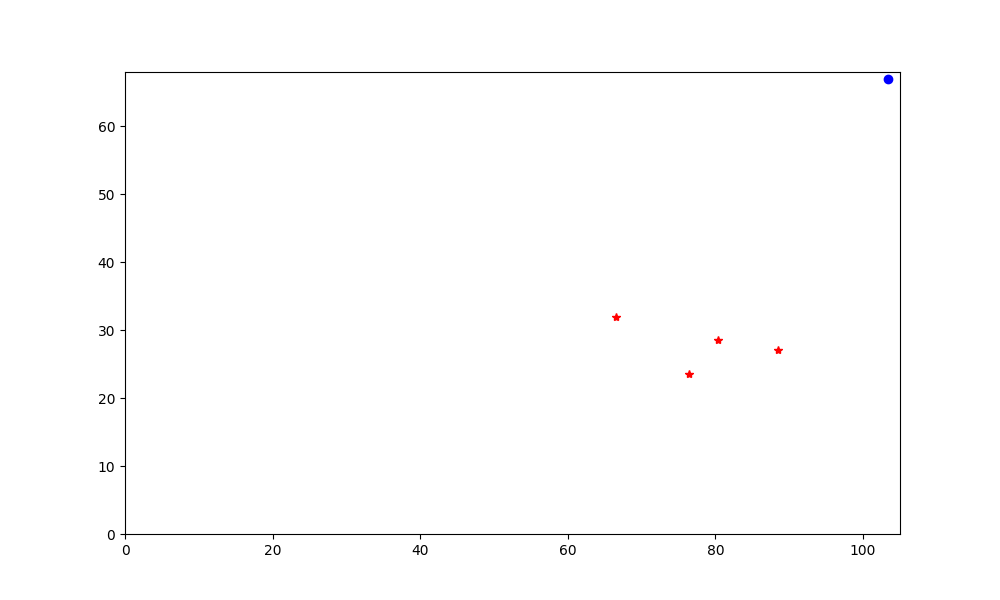

interactive(children=(SelectionSlider(description='ts', options=(1523797351317, 1523797351357, 1523797351397, …

In [9]:
timestamps_list = sorted(list(timestamps))
kickoff_time_ind = np.argmin(np.abs(np.subtract(timestamps_list, kickoff_time)))
kickoff_time_matched = timestamps_list[kickoff_time_ind]
print(kickoff_time, kickoff_time_matched)

%matplotlib notebook

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1, 1, 1)
left, = plt.plot([], '*r')
right, = plt.plot([], '*r')

left_b, = plt.plot([], 'ob')
right_b, = plt.plot([], 'ob')

plt.xlim([0, 105])
plt.ylim([0, 68])

def update(ts=kickoff_time_matched):
    if ts in detections['players']['left']:
        left.set_ydata(detections['players']['left'][ts][:, 1])
        left.set_xdata(detections['players']['left'][ts][:, 0])
    else:
        left.set_ydata([])
        left.set_xdata([])
        
    if ts in detections['players']['right']:
        right.set_ydata(detections['players']['right'][ts][:, 1])
        right.set_xdata(detections['players']['right'][ts][:, 0])
    else:
        right.set_ydata([])
        right.set_xdata([])

    if ts in detections['ball']['left'] and len(detections['ball']['left'][ts]):
        left_b.set_ydata(detections['ball']['left'][ts][:, 1])
        left_b.set_xdata(detections['ball']['left'][ts][:, 0])
    else:
        left_b.set_ydata([])
        left_b.set_xdata([])        
    if ts in detections['ball']['right'] and len(detections['ball']['right'][ts]):
        right_b.set_ydata(detections['ball']['right'][ts][:, 1])
        right_b.set_xdata(detections['ball']['right'][ts][:, 0])
    else:
        right_b.set_ydata([])
        right_b.set_xdata([])
    
    
wid = widgets.SelectionSlider(
    options=timestamps_list,
    value=kickoff_time_matched,
    continuous_update=True,
    orientation='horizontal',
    readout=True
)
    
interact(update, ts = wid);

In [11]:
# {'id': 'd1a98e08-0f21-46fe-8457-01ff183ddbeb', 'calibration': {'views': ['left', 'right'], 'reference_landmarks': {'object': 'calibrations/tele2_landmarks.json', 'bucket': 'signality.ironfist.models'}}, 'replay_urls': ['//liveplay.signality.com/data/d1a98e08-0f21-46fe-8457-01ff183ddbeb_phase1.data', '//liveplay.signality.com/data/d1a98e08-0f21-46fe-8457-01ff183ddbeb_phase2.data'], 'camera_mode': 'static', 'away_team': {'colors': {'team': '#000000', 'goalkeeper': '#ffff00'}, 'logo_url': 'http://images.signality.com/team-logos/orebro.png', 'name': 'Örebro SK'}, 'phase_events': [{'type': 'start_phase', 'ts': datetime.datetime(2018, 5, 17, 17, 0, 2, 362000, tzinfo=<rethinkdb.ast.RqlTzinfo object at 0x7f4d1c61e4e0>), 'kickoff_team_id': 12, 'phase': 1}, {'type': 'end_phase', 'ts': datetime.datetime(2018, 5, 17, 17, 47, 7, 92000, tzinfo=<rethinkdb.ast.RqlTzinfo object at 0x7f4d1c61e518>), 'phase': 1}, {'type': 'start_phase', 'ts': datetime.datetime(2018, 5, 17, 18, 4, 2, 891000, tzinfo=<rethinkdb.ast.RqlTzinfo object at 0x7f4d1c61e630>), 'kickoff_team_id': 11, 'phase': 2}, {'type': 'end_phase', 'ts': datetime.datetime(2018, 5, 17, 18, 52, 6, 565000, tzinfo=<rethinkdb.ast.RqlTzinfo object at 0x7f4d1c61e6a0>), 'phase': 2}], 'start_time': datetime.datetime(2018, 5, 17, 19, 0, tzinfo=<rethinkdb.ast.RqlTzinfo object at 0x7f4d1c61e780>), 'state': 'Destroyed', 'external_data': {'smc': {'match_id': 3704, 'home_team_id': 11, 'league_id': 12, 'away_team_id': 12}}, 'streams': {'left': {'url': 'https://d35u71x3nb8v2y.cloudfront.net/f75295bb-c143-4472-a151-d849f9916e75/ca074983-09a2-451f-8730-90efa6701dc8/playlist.m3u8', 'utc': datetime.datetime(2018, 5, 17, 16, 45, 41, 197000, tzinfo=<rethinkdb.ast.RqlTzinfo object at 0x7f4d1c61e9e8>)}, 'autofollow_render_segments': {'url': 'https://d35u71x3nb8v2y.cloudfront.net/f75295bb-c143-4472-a151-d849f9916e75/d890161e-59fa-4f39-9758-b9d5b10357af/playlist.m3u8', 'utc': datetime.datetime(2018, 5, 17, 16, 45, 41, 197000, tzinfo=<rethinkdb.ast.RqlTzinfo object at 0x7f4d1c61e9b0>)}, 'virtual_panorama_segments': {'url': 'https://d35u71x3nb8v2y.cloudfront.net/f75295bb-c143-4472-a151-d849f9916e75/b5e093f3-f8e7-4643-a87a-d9a76256a735/playlist.m3u8', 'utc': datetime.datetime(2018, 5, 17, 16, 45, 41, 197000, tzinfo=<rethinkdb.ast.RqlTzinfo object at 0x7f4d1c61ec88>)}, 'goal_south_segments': {'url': 'https://d35u71x3nb8v2y.cloudfront.net/f75295bb-c143-4472-a151-d849f9916e75/c841f705-de34-4428-b56e-7c9803ab4eca/playlist.m3u8', 'utc': datetime.datetime(2018, 5, 17, 16, 45, 41, 143000, tzinfo=<rethinkdb.ast.RqlTzinfo object at 0x7f4d1c61eac8>)}, 'right': {'url': 'https://d35u71x3nb8v2y.cloudfront.net/f75295bb-c143-4472-a151-d849f9916e75/d8112841-7cf8-48ae-89ce-f327c282916c/playlist.m3u8', 'utc': datetime.datetime(2018, 5, 17, 16, 45, 41, 124000, tzinfo=<rethinkdb.ast.RqlTzinfo object at 0x7f4d1c61ea20>)}, 'goal_north_segments': {'url': 'https://d35u71x3nb8v2y.cloudfront.net/f75295bb-c143-4472-a151-d849f9916e75/9a7b8e83-dbc0-436b-a116-7f8d085057c2/playlist.m3u8', 'utc': datetime.datetime(2018, 5, 17, 16, 45, 41, 141000, tzinfo=<rethinkdb.ast.RqlTzinfo object at 0x7f4d1c61ea58>)}}, 'pitch_size': [105, 68], 'home_team': {'colors': {'team': '#5a9dde', 'goalkeeper': '#ffffff'}, 'logo_url': 'http://images.signality.com/team-logos/djurgarden.png', 'name': 'Djurgårdens IF'}, 'referees': {'colors': '#000000'}, 'competition': 'Allsvenskan', 'redis': {'host': 'redis', 'port': 6379}, 'rethinkdb': {'host': 'db.signality.com', 'user': 'game_viewer', 'db': 'livetrack', 'ssl': {'ca_certs': '/home/ubuntu/workspace/ironfist/ironfist/utils/../applications/livetrack/config/db.signality.cert.pem'}, 'password': 'MmPHrqmXaVeu', 'port': 28015}, 'nchan': {'url': 'http://nchan:8080'}, 'arena': 'Tele2 Arena', 'stats': [{'home_team': {'failed_passes': 163, 'possessing_team': 0, 'passes': 181, 'distance': 62777.64480394193, 'possession': 25067, 'packing': 260}, 'source': 'signality', 'phase': 1, 'away_team': {'failed_passes': 163, 'possessing_team': 1, 'passes': 191, 'distance': 60097.76136929008, 'possession': 23934, 'packing': 252}, 'utc_time': 1526579225125, 'match_time': 2822763}, {'home_team': {'failed_passes': 157, 'possessing_team': 0, 'passes': 147, 'distance': 62576.815733754884, 'possession': 20009, 'packing': 196}, 'source': 'signality', 'phase': 2, 'away_team': {'failed_passes': 158, 'possessing_team': 1, 'passes': 206, 'distance': 57684.92804763888, 'possession': 28384, 'packing': 240}, 'utc_time': 1526583124565, 'match_time': 2881674}], 'video_shape': [2160, 3840, 3], 'rdb': [{'key': '20180517.djurgårdens-if-örebro-sk.2.rdb', 'bucket': 'signality.soccer.backup', 'phase': 2}]}

In [10]:
def select_time(time_list,detections):
    l=list()
    truth_list=list()
    for i in range(len(time_list)):
        truth_list.append(True)
        if time_list[i] in detections['players']['left'] and time_list[i] in detections['players']['right']:
            l.append([time_list[i],time_list[i]])
            truth_list[i]=False
        if i>0:
            if time_list[i-1] in detections['players']['left'] and time_list[i] in detections['players']['right'] and truth_list[i] and truth_list[i-1] and time_list[i]-time_list[i-1]<=20:
                l.append([time_list[i-1],time_list[i]])
                truth_list[i]=False
            if time_list[i] in detections['players']['left'] and time_list[i-1] in detections['players']['right'] and truth_list[i] and truth_list[i-1] and time_list[i]-time_list[i-1]<=20:
                l.append([time_list[i],time_list[i-1]])
                truth_list[i]=False
    return l

l=select_time(timestamps_list,detections)

In [11]:
def players_grid(pitch_size,players):
    grid=[0 for i in range(32)]
    length=pitch_size[0]
    width=pitch_size[1]
    length_edge=length/8
    width_edge=width/4
    for i in range(len(players)):
        k=0
        j=0
        if players[i][0]<=length and players[i][1]<=width:
            while players[i][0]>(k+1)*length_edge:
                k+=1
            while players[i][1]>(j+1)*width_edge:
                j+=1
            grid[4*j+k]+=1
    return grid

def ball_grid(pitch_size,ball):
    grid=[0 for i in range(35)]
    length=pitch_size[0]
    width=pitch_size[1]
    length_edge=length/7
    width_edge=width/5
    for i in range(len(ball)):
        k=0
        j=0
        if ball[i][0]<=length and ball[i][1]<=width:
            while ball[i][0]>(k+1)*length_edge:
                k+=1
            while ball[i][1]>(j+1)*width_edge:
                j+=1
            grid[7*j+k]+=1
    return grid

In [12]:
def pitch_composition_t(time,detections,pitch_size):
    compo=list()
    if isinstance(detections['ball']['left'][time[0]],list):
        compo=compo+ball_grid(pitch_size,detections['ball']['left'][time[0]])
    if isinstance(detections['ball']['left'][time[0]],np.ndarray):
        compo=compo+ball_grid(pitch_size,detections['ball']['left'][time[0]].tolist())
        
    if isinstance(detections['ball']['right'][time[1]],list):
        compo=compo+ball_grid(pitch_size,detections['ball']['right'][time[1]])
    if isinstance(detections['ball']['right'][time[1]],np.ndarray):
        compo=compo+ball_grid(pitch_size,detections['ball']['right'][time[1]].tolist())
    
    if isinstance(detections['players']['left'][time[0]],list):
        compo=compo+players_grid(pitch_size,detections['players']['left'][time[0]])
    if isinstance(detections['players']['left'][time[0]],np.ndarray):
        compo=compo+players_grid(pitch_size,detections['players']['left'][time[0]].tolist())
        
    if isinstance(detections['players']['right'][time[1]],list):
        compo=compo+players_grid(pitch_size,detections['players']['right'][time[1]])
    if isinstance(detections['players']['right'][time[1]],np.ndarray):
        compo=compo+players_grid(pitch_size,detections['players']['right'][time[1]].tolist())
    return compo
    
def pitch_composition(time_list,detections,pitch_size):
    l=select_time(time_list,detections)
    seq=list()
    for i in range(len(l)):
        seq.append(pitch_composition_t(l[i],detections,pitch_size))
    return seq


In [13]:
def movement_sequences(inputs,outputs):
    inputs=np.array(inputs)
    new_inputs=list()
    new_outputs=list()
    for i in range(len(outputs)-2):
        new_inputs.append(inputs[i+1].tolist()+(inputs[i+1]-inputs[i]).tolist()+(inputs[i+2]-inputs[i]).tolist())
        new_outputs.append(outputs[i+1])
    return new_inputs,new_outputs

def sequence_composition(time_list,detections,pitch_size,size_sequence,diminish_size):
    sequences=list()
    pitch_compo=pitch_composition(time_list,detections,pitch_size)
    for i in range(0,len(pitch_compo)-size_sequence+1,diminish_size):
        seq_t=list()
        for j in range(0,size_sequence,diminish_size):
            seq_t=seq_t+pitch_compo[i+j]
        sequences.append(seq_t)
    return sequences



In [14]:
def labels(time_list,detections,pitch_size,size_sequence,diminish_size,kickoff_time):
    l=select_time(time_list,detections)
    y=list()
    for i in range(0,len(l)-size_sequence+1,diminish_size):
        if max(l[i][0],l[i][1])<=kickoff_time and kickoff_time+2000<=min(l[i+size_sequence-1][0],l[i+size_sequence-1][1]):
            y.append(1)
        else:
            y.append(-1)
    return y

def reduce_size(X,Y,reduc_size):
    compteur=0
    new_X=list()
    new_Y=list()
    for i in range(len(X)):
        if Y[i]==1:
            new_Y.append(1)
            new_X.append(X[i])
            compteur=0
        if Y[i]==-1:
            compteur+=1
        if compteur>=reduc_size:
            compteur=0
            new_Y.append(Y[i])
            new_X.append(X[i])
    return new_X,new_Y
X=sequence_composition(timestamps_list,detections,pitch_size,250,25)
Y=labels(timestamps_list,detections,pitch_size,250,25,kickoff_time_matched)
X,Y=reduce_size(X,Y,10)

In [15]:
tracks_name=['0281a840-f977-4e8a-86e2-eaf67845b528.1.kickoff.rdb','0d9e9e30-9d13-4af0-8e41-fe1669e9eeff.1.kickoff.rdb',
            '19bebd81-3b61-492b-85ed-74ff887cbc45.1.kickoff.rdb','2281c504-baac-4d0b-8cb6-a95c23e3ac87.1.kickoff.rdb',
            '27bea627-3caa-47ee-93c3-67f0e26f3034.1.kickoff.rdb','2b8bcfd6-5f57-46de-aacd-e932ac8e1697.1.kickoff.rdb',
            '2dc12819-d486-4925-a0e2-b8ae9ff1aed5.1.kickoff.rdb','314f4989-398c-45a3-a74f-9f1adac71bf1.1.kickoff.rdb',
            '3382a9d0-02ff-4f23-9748-1b715d85b731.1.kickoff.rdb','3c7f617c-c839-4e5a-9e80-52017fa85d93.1.kickoff.rdb',
             '4be6ef54-2541-42d0-a334-e513a535029c.1.kickoff.rdb','57bf9b24-5c68-464f-9e74-20d0b2508bba.1.kickoff.rdb',
            '58bc418b-cf05-415e-9dd1-6f4808535976.1.kickoff.rdb','5dcb4696-281c-4bff-9ec7-02322c1b4a67.1.kickoff.rdb',
            '6e26f66b-a921-4919-9d7d-1bd59f935e78.1.kickoff.rdb','76d4b783-ae63-4c60-815f-6a81beef6451.1.kickoff.rdb',
            '84e8b33c-d912-495e-9e21-84bdd18e0e04.1.kickoff.rdb','9e627901-09e2-4c84-bf77-6f0ec289fa5f.1.kickoff.rdb',
             'a185c6c8-7383-4d19-927f-dc8f70726c34.1.kickoff.rdb','a5857e03-10b8-454a-89fb-c201985b04cb.1.kickoff.rdb',
            'af42c9ca-ae8f-4d69-a671-15950883ecac.1.kickoff.rdb','b0cbf7ed-a9ce-4434-9e4d-072065ee61bc.1.kickoff.rdb',
            'b4dbea7c-c72f-4dd6-b57c-8fb7b8b38eb5.1.kickoff.rdb','ba34fc2e-bdba-40d8-8cc8-a679c6eecd5a.1.kickoff.rdb',
            'bff5f37c-be85-4f08-b6d4-a01e6c22fe0e.1.kickoff.rdb','c79d79f1-5f51-4595-b931-4719f91a4575.1.kickoff.rdb',
            'cbcca433-ff77-4927-a5a3-36ff293c12fd.1.kickoff.rdb','cf16ebf4-49fc-4991-a9b8-b9a055dcf2b8.1.kickoff.rdb',
             'f9f01fbf-6871-4303-b43f-29c2dd16909d.1.kickoff.rdb']        

config_name=['0281a840-f977-4e8a-86e2-eaf67845b528.json','0d9e9e30-9d13-4af0-8e41-fe1669e9eeff.json',
             '19bebd81-3b61-492b-85ed-74ff887cbc45.json','2281c504-baac-4d0b-8cb6-a95c23e3ac87.json',
            '27bea627-3caa-47ee-93c3-67f0e26f3034.json','2b8bcfd6-5f57-46de-aacd-e932ac8e1697.json',
             '2dc12819-d486-4925-a0e2-b8ae9ff1aed5.json','314f4989-398c-45a3-a74f-9f1adac71bf1.json',
            '3382a9d0-02ff-4f23-9748-1b715d85b731.json','3c7f617c-c839-4e5a-9e80-52017fa85d93.json',
            '4be6ef54-2541-42d0-a334-e513a535029c.json','57bf9b24-5c68-464f-9e74-20d0b2508bba.json',
            '58bc418b-cf05-415e-9dd1-6f4808535976.json','5dcb4696-281c-4bff-9ec7-02322c1b4a67.json',
            '6e26f66b-a921-4919-9d7d-1bd59f935e78.json','76d4b783-ae63-4c60-815f-6a81beef6451.json',
            '84e8b33c-d912-495e-9e21-84bdd18e0e04.json','9e627901-09e2-4c84-bf77-6f0ec289fa5f.json',
            'a185c6c8-7383-4d19-927f-dc8f70726c34.json','a5857e03-10b8-454a-89fb-c201985b04cb.json',
            'af42c9ca-ae8f-4d69-a671-15950883ecac.json','b0cbf7ed-a9ce-4434-9e4d-072065ee61bc.json',
            'b4dbea7c-c72f-4dd6-b57c-8fb7b8b38eb5.json','ba34fc2e-bdba-40d8-8cc8-a679c6eecd5a.json',
            'bff5f37c-be85-4f08-b6d4-a01e6c22fe0e.json','c79d79f1-5f51-4595-b931-4719f91a4575.json',
            'cbcca433-ff77-4927-a5a3-36ff293c12fd.json','cf16ebf4-49fc-4991-a9b8-b9a055dcf2b8.json',
             'f9f01fbf-6871-4303-b43f-29c2dd16909d.json']          

In [16]:
import pickle

In [17]:
def create_dataset(tracks_name,config_name,file_name,reduc_size):
    for i in range(len(tracks_name)):
        tracks = parse_dump_file('../kickoff-detection-data/'+tracks_name[i])
        config = json.load(open('../kickoff-detection-data/'+config_name[i], 'r'))
        fd, ts = tracks['left'][0]
        fd = pickle.loads(fd)
        kickoff_1 = config['phase_events'][0]['ts']
        kickoff_time = int(parse(kickoff_1).timestamp()*1000)
        pitch_size=config['pitch_size']
        detections = {'ball':{'left':{}, 'right':{}}, 'players':{'left':{}, 'right':{}}}
        timestamps = set()
        for (fd_left, ts_left), (fd_right, ts_right) in tqdm(zip(tracks['left'], tracks['right'])):
            fd_left = pickle.loads(fd_left)
            fd_right = pickle.loads(fd_right)
            if np.abs(ts_left - ts_right) < 100:
                ts_left = ts_right
            timestamps.update({ts_left, ts_right})
            detections['players']['left'][ts_left] = fd_left.top_view_player_positions
            detections['players']['right'][ts_right] = fd_right.top_view_player_positions
            detections['ball']['left'][ts_left] = np.array([bp for bp, bd in zip(fd_left.top_view_ball_positions, fd_left.ball_detections) if ball_ok(bp, bd)])
            detections['ball']['right'][ts_right] = np.array([bp for bp, bd in zip(fd_right.top_view_ball_positions, fd_right.ball_detections) if ball_ok(bp, bd)])
        timestamps_list = sorted(list(timestamps))
        kickoff_time_ind = np.argmin(np.abs(np.subtract(timestamps_list, kickoff_time)))
        kickoff_time_matched = timestamps_list[kickoff_time_ind]
        
        #Create inputs
        X=sequence_composition(timestamps_list,detections,pitch_size,500,25)
        Y=labels(timestamps_list,detections,pitch_size,500,25,kickoff_time_matched)
        X,Y=movement_sequences(X,Y)
        X,Y=reduce_size(X,Y,reduc_size)
        print(len(X[0]),len(Y))
        print(Y.count(1))
        
        #Create file
        if i==0:
            with open(file_name, 'wb') as f:
                # Pickle the 'data' dictionary using the highest protocol available.
                pickle.dump([X,Y], f)
        if i>0:
            with open(file_name, 'ab') as f:
                # Pickle the 'data' dictionary using the highest protocol available.
                pickle.dump([X,Y], f)
            
        

In [266]:
create_dataset(tracks_name,config_name,'../kickoff-detection-data/data.pickle_reduce10movaccbis',10)

239it [00:00, 1186.65it/s]

Parsed ../kickoff-detection-data/0281a840-f977-4e8a-86e2-eaf67845b528.1.kickoff.rdb in 1.76 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1525015525720 | stop_ts: 1525016123520
[right] start_ts: 1525015525634 | stop_ts: 1525016123474


14947it [00:08, 1699.13it/s]


8040 72
18


487it [00:00, 2491.24it/s]

Parsed ../kickoff-detection-data/0d9e9e30-9d13-4af0-8e41-fe1669e9eeff.1.kickoff.rdb in 1.85 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523192129517 | stop_ts: 1523192728157
[right] start_ts: 1523192129071 | stop_ts: 1523192727911


14966it [00:08, 1744.40it/s]


8040 73
18


405it [00:00, 2107.52it/s]

Parsed ../kickoff-detection-data/19bebd81-3b61-492b-85ed-74ff887cbc45.1.kickoff.rdb in 1.97 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1522587371575 | stop_ts: 1522587969015
[right] start_ts: 1522587371411 | stop_ts: 1522587968931


14937it [00:08, 1785.78it/s]


8040 72
18


400it [00:00, 3993.02it/s]

Parsed ../kickoff-detection-data/2281c504-baac-4d0b-8cb6-a95c23e3ac87.1.kickoff.rdb in 1.10 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1525096495433 | stop_ts: 1525097093953
[right] start_ts: 1525096495413 | stop_ts: 1525097093933


14964it [00:05, 2680.82it/s]


8040 73
18


452it [00:00, 2251.61it/s]

Parsed ../kickoff-detection-data/27bea627-3caa-47ee-93c3-67f0e26f3034.1.kickoff.rdb in 1.79 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523796958381 | stop_ts: 1523797557661
[right] start_ts: 1523796957851 | stop_ts: 1523797557411


14984it [00:08, 1792.82it/s]


8040 73
18


758it [00:00, 3647.85it/s]

Parsed ../kickoff-detection-data/2b8bcfd6-5f57-46de-aacd-e932ac8e1697.1.kickoff.rdb in 1.54 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523201092829 | stop_ts: 1523201692349
[right] start_ts: 1523201094061 | stop_ts: 1523201692981


14951it [00:08, 1864.09it/s]


8040 73
18


258it [00:00, 1283.54it/s]

Parsed ../kickoff-detection-data/2dc12819-d486-4925-a0e2-b8ae9ff1aed5.1.kickoff.rdb in 1.99 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523192332019 | stop_ts: 1523192929339
[right] start_ts: 1523192332775 | stop_ts: 1523192929695


14925it [00:09, 1629.73it/s]


8040 72
18


119it [00:00, 1186.14it/s]

Parsed ../kickoff-detection-data/314f4989-398c-45a3-a74f-9f1adac71bf1.1.kickoff.rdb in 1.80 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1522587361524 | stop_ts: 1522587961404
[right] start_ts: 1522587361602 | stop_ts: 1522587961442


14908it [00:08, 1859.05it/s]


8040 73
18


145it [00:00, 1449.02it/s]

Parsed ../kickoff-detection-data/3382a9d0-02ff-4f23-9748-1b715d85b731.1.kickoff.rdb in 2.28 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523805900082 | stop_ts: 1523806498882
[right] start_ts: 1523805900650 | stop_ts: 1523806499170


14963it [00:10, 1406.47it/s]


8040 72
18


822it [00:00, 4228.65it/s]

Parsed ../kickoff-detection-data/3c7f617c-c839-4e5a-9e80-52017fa85d93.1.kickoff.rdb in 1.47 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1525006516949 | stop_ts: 1525007115789
[right] start_ts: 1525006516933 | stop_ts: 1525007115773


14972it [00:07, 2034.08it/s]


8040 73
18


319it [00:00, 3185.87it/s]

Parsed ../kickoff-detection-data/4be6ef54-2541-42d0-a334-e513a535029c.1.kickoff.rdb in 1.58 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523714121022 | stop_ts: 1523714720662
[right] start_ts: 1523714121038 | stop_ts: 1523714720678


14991it [00:08, 1793.65it/s]


8040 74
18


228it [00:00, 1116.62it/s]

Parsed ../kickoff-detection-data/57bf9b24-5c68-464f-9e74-20d0b2508bba.1.kickoff.rdb in 1.90 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1524070530135 | stop_ts: 1524071127975
[right] start_ts: 1524070530793 | stop_ts: 1524071128313


14939it [00:09, 1594.36it/s]


8040 72
18


262it [00:00, 1270.29it/s]

Parsed ../kickoff-detection-data/58bc418b-cf05-415e-9dd1-6f4808535976.1.kickoff.rdb in 1.76 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523292956846 | stop_ts: 1523293556726
[right] start_ts: 1523292957288 | stop_ts: 1523293556968


14992it [00:08, 1797.60it/s]


8040 73
18


402it [00:00, 1972.38it/s]

Parsed ../kickoff-detection-data/5dcb4696-281c-4bff-9ec7-02322c1b4a67.1.kickoff.rdb in 1.97 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1525015503674 | stop_ts: 1525016102514
[right] start_ts: 1525015503710 | stop_ts: 1525016102510


14971it [00:08, 1755.58it/s]


8040 73
18


228it [00:00, 1133.00it/s]

Parsed ../kickoff-detection-data/6e26f66b-a921-4919-9d7d-1bd59f935e78.1.kickoff.rdb in 1.69 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523638587613 | stop_ts: 1523639186133
[right] start_ts: 1523638586979 | stop_ts: 1523639185819


14963it [00:08, 1782.06it/s]


8040 73
18


82it [00:00, 818.91it/s]

Parsed ../kickoff-detection-data/76d4b783-ae63-4c60-815f-6a81beef6451.1.kickoff.rdb in 1.86 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523109442596 | stop_ts: 1523110041116
[right] start_ts: 1523109442628 | stop_ts: 1523110041148


14963it [00:09, 1574.12it/s]


8040 73
18


538it [00:00, 2789.74it/s]

Parsed ../kickoff-detection-data/84e8b33c-d912-495e-9e21-84bdd18e0e04.1.kickoff.rdb in 1.62 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523638501659 | stop_ts: 1523639099539
[right] start_ts: 1523638502169 | stop_ts: 1523639099769


14940it [00:07, 1981.79it/s]


8040 72
18


231it [00:00, 2304.31it/s]

Parsed ../kickoff-detection-data/9e627901-09e2-4c84-bf77-6f0ec289fa5f.1.kickoff.rdb in 1.62 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1522682846069 | stop_ts: 1522683445869
[right] start_ts: 1522682845973 | stop_ts: 1522683445853


14997it [00:06, 2438.82it/s]


8040 74
18


254it [00:00, 1277.63it/s]

Parsed ../kickoff-detection-data/a185c6c8-7383-4d19-927f-dc8f70726c34.1.kickoff.rdb in 2.24 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523897795243 | stop_ts: 1523898395043
[right] start_ts: 1523897795697 | stop_ts: 1523898395297


14991it [00:10, 1371.65it/s]


8040 73
18


181it [00:00, 867.86it/s]

Parsed ../kickoff-detection-data/a5857e03-10b8-454a-89fb-c201985b04cb.1.kickoff.rdb in 1.42 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523379375938 | stop_ts: 1523379974138
[right] start_ts: 1523379375326 | stop_ts: 1523379973846


14955it [00:06, 2181.51it/s]


8040 73
18


261it [00:00, 1295.56it/s]

Parsed ../kickoff-detection-data/af42c9ca-ae8f-4d69-a671-15950883ecac.1.kickoff.rdb in 2.26 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1524923719596 | stop_ts: 1524924319436
[right] start_ts: 1524923719612 | stop_ts: 1524924319452


14997it [00:10, 1476.01it/s]


8040 73
18


793it [00:00, 4122.08it/s]

Parsed ../kickoff-detection-data/b0cbf7ed-a9ce-4434-9e4d-072065ee61bc.1.kickoff.rdb in 1.36 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523706904558 | stop_ts: 1523707503158
[right] start_ts: 1523706912088 | stop_ts: 1523707510928


14966it [00:05, 2508.08it/s]


8040 72
18


347it [00:00, 1673.74it/s]

Parsed ../kickoff-detection-data/b4dbea7c-c72f-4dd6-b57c-8fb7b8b38eb5.1.kickoff.rdb in 2.20 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1524070510939 | stop_ts: 1524071110739
[right] start_ts: 1524070510889 | stop_ts: 1524071110729


14996it [00:10, 1482.62it/s]


8040 73
18


158it [00:00, 570.86it/s]

Parsed ../kickoff-detection-data/ba34fc2e-bdba-40d8-8cc8-a679c6eecd5a.1.kickoff.rdb in 1.39 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1522596366681 | stop_ts: 1522596965521
[right] start_ts: 1522596366671 | stop_ts: 1522596965511


14972it [00:06, 2157.63it/s]


8040 73
18


380it [00:00, 3790.91it/s]

Parsed ../kickoff-detection-data/bff5f37c-be85-4f08-b6d4-a01e6c22fe0e.1.kickoff.rdb in 1.62 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523984148353 | stop_ts: 1523984746873
[right] start_ts: 1523984147529 | stop_ts: 1523984746449


14964it [00:08, 1866.19it/s]


8040 73
18


0it [00:00, ?it/s]

Parsed ../kickoff-detection-data/c79d79f1-5f51-4595-b931-4719f91a4575.1.kickoff.rdb in 1.74 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1525103807965 | stop_ts: 1525104404805
[right] start_ts: 1525103808005 | stop_ts: 1525104404845


14922it [00:07, 1866.04it/s]


8040 72
18


384it [00:00, 3831.45it/s]

Parsed ../kickoff-detection-data/cbcca433-ff77-4927-a5a3-36ff293c12fd.1.kickoff.rdb in 1.34 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523292948088 | stop_ts: 1523293544248
[right] start_ts: 1523292936370 | stop_ts: 1523293534370


14861it [00:06, 2426.72it/s]


8040 71
18


248it [00:00, 1202.60it/s]

Parsed ../kickoff-detection-data/cf16ebf4-49fc-4991-a9b8-b9a055dcf2b8.1.kickoff.rdb in 1.78 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1525006796874 | stop_ts: 1525007393674
[right] start_ts: 1525006796888 | stop_ts: 1525007393688


14921it [00:08, 1847.01it/s]


8040 72
18


413it [00:00, 2032.07it/s]

Parsed ../kickoff-detection-data/f9f01fbf-6871-4303-b43f-29c2dd16909d.1.kickoff.rdb in 1.85 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1522673702294 | stop_ts: 1522674302134
[right] start_ts: 1522673702216 | stop_ts: 1522674302096


14996it [00:08, 1751.73it/s]


8040 73
18


In [18]:
import random

def shuffle_data(X,Y):
    shuffle_list=list()
    shuffle_X=list()
    shuffle_Y=list()
    for i in range(len(Y)):
        shuffle_list.append([X[i],Y[i]])
    random.shuffle(shuffle_list)
    for i in range(len(Y)):
        shuffle_X.append(shuffle_list[i][0])
        shuffle_Y.append(shuffle_list[i][1])
    return shuffle_X,shuffle_Y

def sequence_kickoff_time(Y):
    kickoff_match_i=list()
    kickoff_periods=list()
    for i in range(len(Y)):
        if Y[i]==-1 and len(kickoff_match_i)>0:
            kickoff_periods.append(kickoff_match_i)
            kickoff_match_i=list()
        if Y[i]==1:
            kickoff_match_i.append(i)
    if len(kickoff_match_i)>0:
        kickoff_periods.append(kickoff_match_i)
    return kickoff_periods



In [19]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import NearestNeighbors
from sklearn.tree import DecisionTreeClassifier
from datetime import datetime
def cross_validation(X,Y,name_classifier,percentage_train,nbre_matches,indices,type_cross):
    score_test=0
    score_train=0
    start=datetime.now()
    for i in range(nbre_matches):
        start_i=datetime.now()
        #Create training and test datasets
        x_train1=X[indices[i]:indices[min(i+int(nbre_matches*percentage_train),nbre_matches)]]+X[:indices[max(0,i+int(nbre_matches*percentage_train)-nbre_matches)]]
        y_train1=Y[indices[i]:indices[min(i+int(nbre_matches*percentage_train),nbre_matches)]]+Y[:indices[max(0,i+int(nbre_matches*percentage_train)-nbre_matches)]]
        x_test1=X[indices[min(i+int(nbre_matches*percentage_train),nbre_matches)]:]+X[indices[max(0,i+int(nbre_matches*percentage_train)-nbre_matches)]:indices[i]]
        y_test1=Y[indices[min(i+int(nbre_matches*percentage_train),nbre_matches)]:]+Y[indices[max(0,i+int(nbre_matches*percentage_train)-nbre_matches)]:indices[i]]
        
        
        #Cross_validation kickoff
        if type_cross=="kickoff":
            kickoff_indices=sequence_kickoff_time(y_test1)
            x_test2=list()
            y_test2=list()
            for j in range(len(kickoff_indices)):
                y_test2=y_test2+y_test1[kickoff_indices[j][0]:kickoff_indices[j][-1]+1]
                x_test2=x_test2+x_test1[kickoff_indices[j][0]:kickoff_indices[j][-1]+1]
            y_test=y_test2
            x_test=x_test2
        
        if type_cross=="no kickoff":
            kickoff_indices=sequence_kickoff_time(y_test1)
            x_test2=list()
            y_test2=list()
            for j in range(len(kickoff_indices)):
                if j==0:
                    y_test2=y_test1[:kickoff_indices[j][0]]
                    x_test2=x_test1[:kickoff_indices[j][0]]
                if j>0:
                    y_test2=y_test2+y_test1[kickoff_indices[j-1][-1]+1:kickoff_indices[j][0]]
                    x_test2=x_test2+x_test1[kickoff_indices[j-1][-1]+1:kickoff_indices[j][0]]
                if j==len(kickoff_indices)-1:
                    y_test2=y_test2+y_test1[kickoff_indices[j][-1]+1:]
                    x_test2=x_test2+x_test1[kickoff_indices[j][-1]+1:]
            y_test=y_test2
            x_test=x_test2
            
        #Shuffle data
        x_train,y_train=shuffle_data(x_train1,y_train1)
        #x_test,y_test=shuffle_data(x_test1,y_test1)
        
        #Training classifier
        if name_classifier=='adaboost':
            clf=AdaBoostClassifier()
            clf.fit(x_train,y_train)
        if name_classifier=='gradaboost':
            clf=GradientBoostingClassifier()
            clf.fit(x_train,y_train)
        if name_classifier=='svm':
            clf=SVC()
            clf.fit(x_train,y_train)
        if name_classifier=='linear_svm':
            clf=LinearSVC()
            clf.fit(x_train,y_train)
        if name_classifier=='knn':
            clf=NearestNeighbors()
            clf.fit(x_train,y_train)
        if name_classifier=='tree':
            clf=DecisionTreeClassifier()
            clf.fit(x_train,y_train)
        if name_classifier=='forest':
            clf=RandomForestClassifier(n_estimators=7,max_depth=20)
            clf.fit(x_train,y_train)
        end_i=datetime.now()
        #Test
        #print(clf.predict(x_test)*np.array(y_test))
        score_test+=clf.score(x_test,y_test)
        score_train+=clf.score(x_train,y_train)
        print("Score for training for iteration {0} is {1}".format(i,clf.score(x_train,y_train)))
        print("Score for testing for iteration {0} is {1}".format(i,clf.score(x_test,y_test)))
        print("Training time: {0}".format(end_i-start_i))
        print("\n")
    
    end=datetime.now()
    print("Final Score train: {0}".format(score_train/nbre_matches))
    print("Final Score test: {0}".format(score_test/nbre_matches))
    print("Cross validation time: {0}".format(end-start))
        
        
        
def Classification(dataset,percentage_train,name_classifier,nbre_matches,type_cross=""):
    #Create inputs
    X=list()
    Y=list()
    indices=[0]
    with open(dataset, 'rb') as f:
        for i in range(nbre_matches):
            data = pickle.load(f)
            X=X+data[0]
            Y=Y+data[1]
            indices.append(len(Y))
    cross_validation(X,Y,name_classifier,percentage_train,nbre_matches,indices,type_cross)

    



In [20]:
Classification('../kickoff-detection-data/data.pickle_reduce10movacc',0.97,'forest',29,"kickoff")

Score for training for iteration 0 is 0.9933367503844183
Score for testing for iteration 0 is 0.7857142857142857
Training time: 0:00:01.352532


Score for training for iteration 1 is 0.9953869810353665
Score for testing for iteration 1 is 0.07142857142857142
Training time: 0:00:01.268563


Score for training for iteration 2 is 0.9943618657098924
Score for testing for iteration 2 is 0.0
Training time: 0:00:01.236200


Score for training for iteration 3 is 0.9969246540235777
Score for testing for iteration 3 is 0.6428571428571429
Training time: 0:00:01.244493


Score for training for iteration 4 is 0.9979497693490518
Score for testing for iteration 4 is 0.0
Training time: 0:00:01.264804


Score for training for iteration 5 is 0.9969246540235777
Score for testing for iteration 5 is 1.0
Training time: 0:00:01.256242


Score for training for iteration 6 is 0.9959016393442623
Score for testing for iteration 6 is 0.35714285714285715
Training time: 0:00:01.243832


Score for training for itera

In [90]:
np.array([1,2])*np.array([3,2])

array([3, 4])

In [187]:
np.array([1,2])-np.array([4,3])

array([-3, -1])